In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_db_url

In [6]:
# where to save data to use later when we need to reload df
filename = 'zillow.csv'

# sql query. 261 -> 'Single Family Residential' (use to avoid joins)
sql = '''
SELECT id, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017
WHERE propertylandusetypeid = 261
'''
# url to get an access to zillow data base
url = get_db_url('zillow')
    # if file is available locally, read it
# read the db and save the info into df
df = pd.read_sql(sql, url)

# save df to csv file, so we don't acquire the file from mysql
df.to_csv(filename, index_label = False)

In [7]:
# if I need to reload data
df = pd.read_csv('zillow.csv')

In [175]:
# rows, columns
df.shape

(2152863, 8)

In [8]:
# descriptive statistic
round(df.describe(), 3)

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
count,2152863.000,2152852.000,2152852.000,2144379.000,2.152370e+06,2143526.000,2148421.000,2152863.000
mean,1490833.552,3.287,2.231,1862.855,4.618962e+05,1960.950,5634.866,6048.377
std,860878.471,0.955,0.999,1222.125,6.996761e+05,22.162,8178.910,20.433
min,1.000,0.000,0.000,1.000,1.000000e+00,1801.000,1.850,6037.000
25%,745117.000,3.000,2.000,1257.000,1.881702e+05,1949.000,2534.980,6037.000
50%,1490613.000,3.000,2.000,1623.000,3.276710e+05,1958.000,4108.950,6037.000
75%,2235859.500,4.000,3.000,2208.000,5.345270e+05,1976.000,6414.320,6059.000
max,2982282.000,25.000,32.000,952576.000,9.842891e+07,2016.000,1337755.860,6111.000


In [11]:
df[df.calculatedfinishedsquarefeet == 1]

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
58438,80982,2.0,1.0,1.0,121376.0,1907.0,1996.35,6037.0
1046787,1449989,0.0,0.0,1.0,28091.0,1963.0,439.55,6037.0
1276353,1768213,1.0,3.0,1.0,124906.0,1953.0,2020.66,6037.0
1359288,1882887,2.0,1.0,1.0,147577.0,1991.0,1855.40,6037.0
1895866,2626112,5.0,5.0,1.0,563977.0,1997.0,6808.84,6037.0
2017745,2795091,3.0,1.0,1.0,31800.0,1900.0,870.36,6037.0


In [45]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 0 to 2152862
Data columns (total 8 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            2152863 non-null  int64  
 1   bedroomcnt                    2152852 non-null  float64
 2   bathroomcnt                   2152852 non-null  float64
 3   calculatedfinishedsquarefeet  2144379 non-null  float64
 4   taxvaluedollarcnt             2152370 non-null  float64
 5   yearbuilt                     2143526 non-null  float64
 6   taxamount                     2148421 non-null  float64
 7   fips                          2152863 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 147.8 MB


### Takeaways from ```info()``` and ```describe()```
- there is square feet = 1
- many null values
- fips min and median are the same!


In [171]:
# check fips unique values()
df.fips.unique()

array([6037., 6059., 6111.])

Only 3 unique values in ```fips``` and they are integers saved as ```float```

In [172]:
# transform fips into integer
df['fips'] = df.loc[:, 'fips'].astype(int)

### Explore how the data is distributed

In [179]:
columns_to_explore = list(df.columns[1:-1])
columns_to_explore

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount']

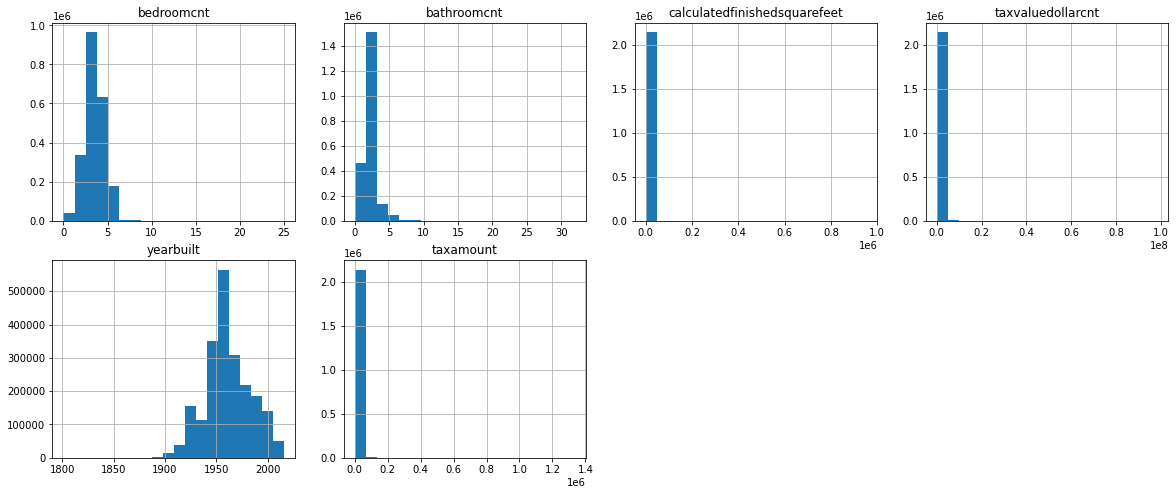

In [181]:
plt.figure(figsize=(20,8))
for i, col in enumerate(columns_to_explore):
    h =  ((i+2) // 4)
    subplot_number = (i+1) 
    plt.subplot(2, 4, subplot_number)
    plt.title(col)
    df[col].hist(bins = 20)

### Takeaway from histograms
- ```yearbuilt``` and ```bedroomcnt``` are realativelly normal distributed but must have some outliers as well.

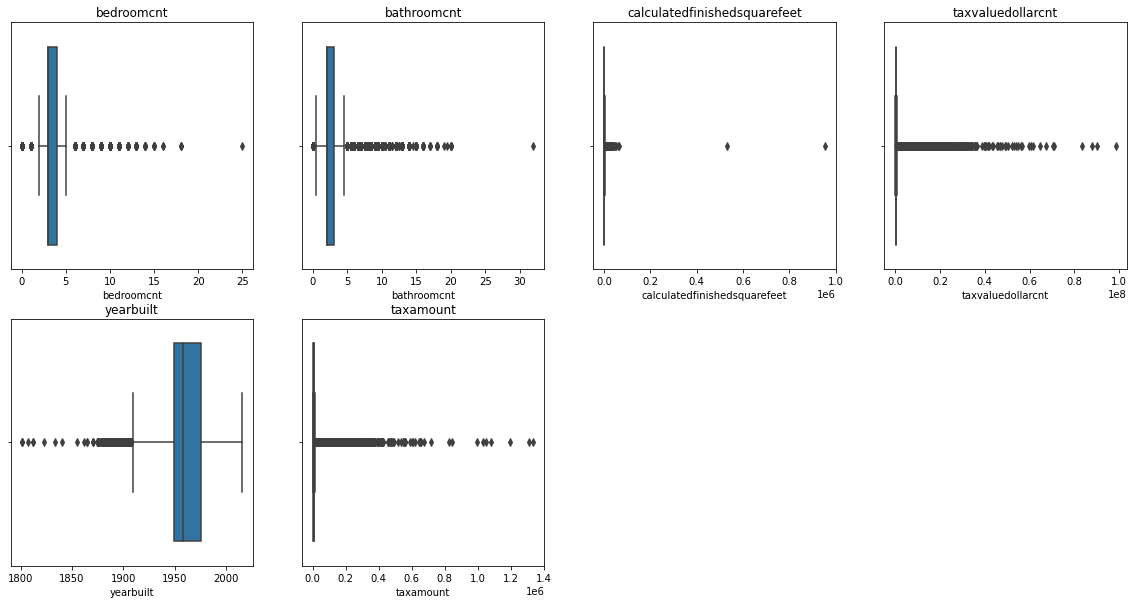

In [182]:
# check for outliers with boxplots
plt.figure(figsize=(20,10))
for i, col in enumerate(columns_to_explore):
    h =  ((i+2) // 4)
    subplot_number = (i+1) 
    plt.subplot(2, 4, subplot_number)
    plt.title(col)
    sns.boxplot(x=col, data=df)

The dataset is full of outliers, specially ```taxvaluedollarcount```

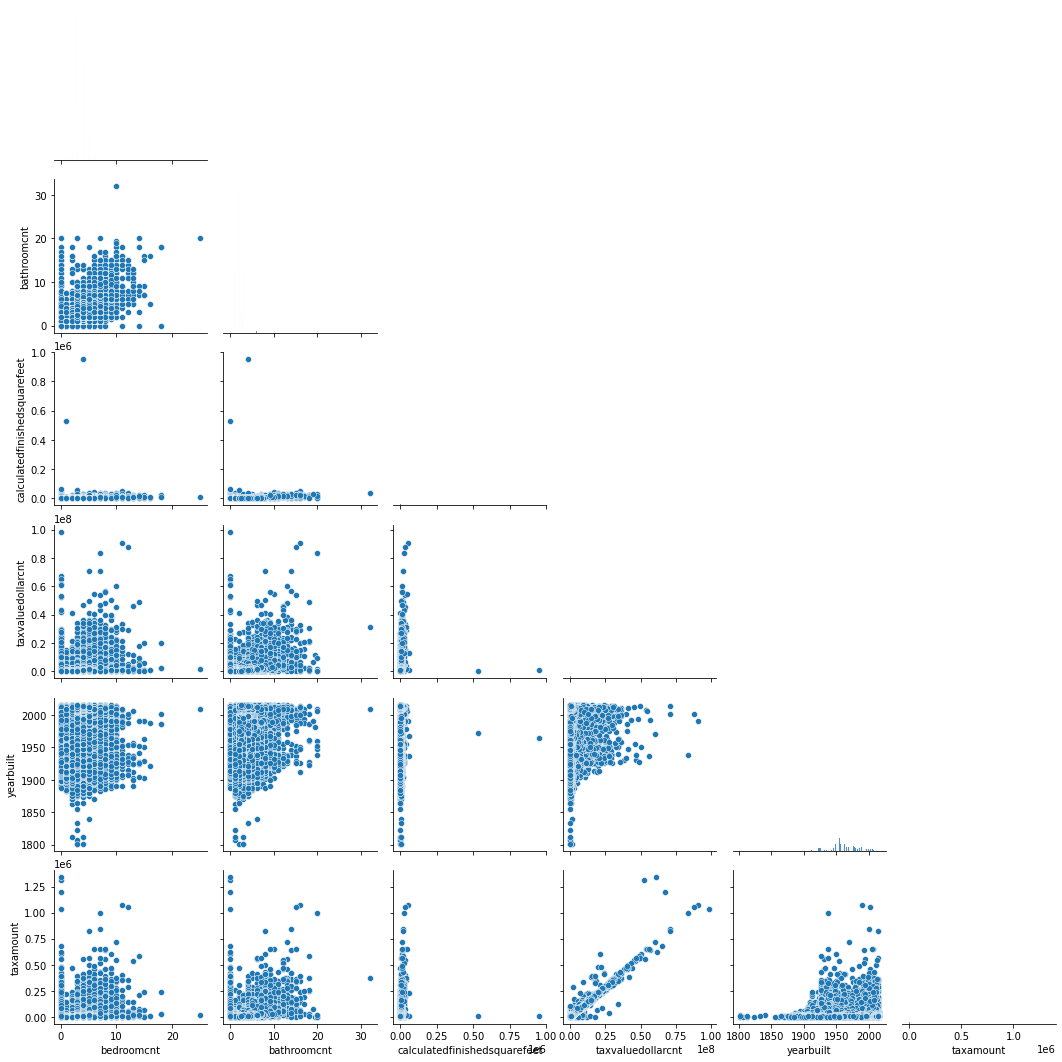

In [183]:
### check for correlations
sns.pairplot(data=df[columns_to_explore], corner=True)

### Takeaway from paiplot 
- there is a correlation beween ```tavvaluedollarcnt``` and ```taxamount```

What if we remove outliers in some columns? I dont touch at the moment ```taxvaluedollarcnt``` as there are way to many outliers

In [184]:
columns_with_outliers = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']

In [185]:
for col in columns_with_outliers:
    q_low = df[col].quantile(0.01)
    q_hi  = df[col].quantile(0.99)

    df = df[(df[col] < q_hi) & (df[col] > q_low)]

In [144]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616417 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1616417 non-null  int64  
 1   bedroomcnt                    1616417 non-null  float64
 2   bathroomcnt                   1616417 non-null  float64
 3   calculatedfinishedsquarefeet  1616417 non-null  float64
 4   taxvaluedollarcnt             1616377 non-null  float64
 5   yearbuilt                     1615754 non-null  float64
 6   taxamount                     1615353 non-null  float64
 7   fips                          1616417 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 111.0 MB


In [206]:
# there were too many rows removed, alomst 1 million
# reload df
df = pd.read_csv('zillow.csv')
df['fips'] = df.loc[:, 'fips'].astype(int)
rows_beginning = len(df.index)

How many rows are in the df where bedromms, bathrooms and year are null values?

In [196]:
# only 4 rows, doesn't solve the problem with nulls

len(df[(df.yearbuilt.isnull()) & (df.bedroomcnt.isnull()) & (df.bathroomcnt.isnull())])

4

In [12]:
#remove all rows with null values
df = df.dropna()

In [198]:
df.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   id                            int64  
 1   bedroomcnt                    float64
 2   bathroomcnt                   float64
 3   calculatedfinishedsquarefeet  float64
 4   taxvaluedollarcnt             float64
 5   yearbuilt                     float64
 6   taxamount                     float64
 7   fips                          int64  
dtypes: float64(6), int64(2)
memory usage: 147.0 MB


In [208]:
rows_end = len(df.index)

In [209]:
print(f'{rows_beginning - rows_end} rows were removed')

12628 rows were removed


12,628 out of the 2,152,863 entries were removed

In [210]:
# put successfull steps into the function

def get_zillow():
    '''
    acuires data from codeup data base
    returns a pandas dataframe with
    'Single Family Residential' properties of 2017
    from zillow
    '''
    
    filename = 'zillow.csv'
    sql = '''
    SELECT *
    FROM properties_2017
    WHERE propertylandusetypeid = 261
    '''

    url = get_db_url('zillow')
    
    # if csv file is available locally, read data from it
    if os.path.isfile(filename):
        df = pd.read_csv(filename) 
    
    # if *.csv file is not available locally, acquire data from SQL database
    # and write it as *.csv for future use
    else:
        # read the SQL query into a dataframe
        df =  pd.read_sql(sql, url)
        
        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index_label = False)
    
    # transform fips to integer
    df['fips'] = df.loc[:, 'fips'].astype(int)
    #remove null values   
    df = df.dropna()
    
    return df 


In [211]:
#check if the function works
get_zillow().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   id                            int64  
 1   bedroomcnt                    float64
 2   bathroomcnt                   float64
 3   calculatedfinishedsquarefeet  float64
 4   taxvaluedollarcnt             float64
 5   yearbuilt                     float64
 6   taxamount                     float64
 7   fips                          int64  
dtypes: float64(6), int64(2)
memory usage: 147.0 MB


In [16]:
#dropped very small and unrealistic square feet
df = df[df.calculatedfinishedsquarefeet > 100]

In [18]:
df.shape

(2140118, 8)